In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import theano
theano.config.floatX = 'float32'
theano.config.openmp = True
import theano.tensor as T
import lasagne
%load_ext autoreload
%autoreload 2

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
_shared = lambda name,val,dtype: theano.shared(val.astype(dtype),name,
                                               strict = True,allow_downcast=True)
floatX = theano.config.floatX

# problem statement

In [3]:
arr_len = 25
n_rules = 15

rule_lengths = np.random.normal(3,2,size=n_rules).astype(int)
rule_lengths[rule_lengths<1] = 1

rule_starts = np.random.randint(0,arr_len-1,size=n_rules)

rules = map(lambda x0,l: np.arange(x0,min(x0+l, arr_len)) , rule_starts, rule_lengths)
rules = np.array(rules)

rule_probas = np.repeat(0.5,n_rules)

In [4]:
from itertools import product

def generate_event():
    rule_triggered = rule_probas > np.random.random(size = n_rules)
    rule_triggered = rule_triggered.astype(bool)
    
    arr = np.zeros(arr_len+1).astype(bool) #last one element is needed for theano switch simplicity
    if np.any(rule_triggered):
        arr[np.concatenate(rules[rule_triggered])] = True
    return arr



[array([16, 17, 18]) array([17, 18, 19]) array([ 9, 10, 11])
 array([16, 17]) array([10, 11, 12]) array([15, 16, 17]) array([23])
 array([19]) array([14, 15, 16, 17]) array([18, 19, 20])
 array([14, 15, 16]) array([2, 3, 4]) array([17]) array([0, 1, 2, 3])
 array([16, 17, 18, 19])]


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


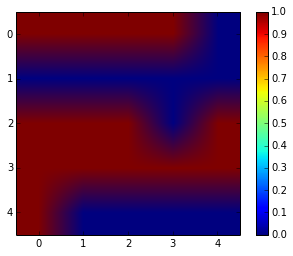

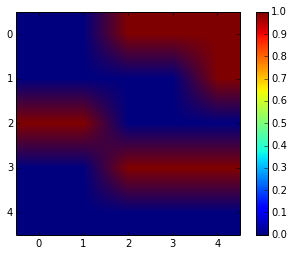

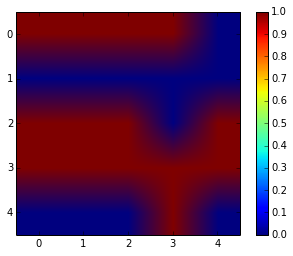

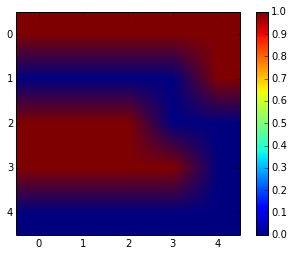

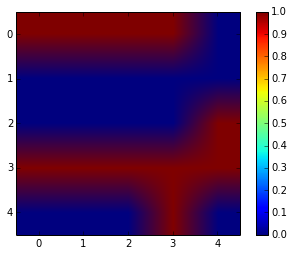

In [5]:
print rules
for i in range(5):
    plt.imshow(generate_event()[:-1].reshape(-1,5))
    plt.colorbar()
    plt.show()

# naive q-learning

In [28]:
class PracticeEnvironment:
    def __init__(self,n_outputs,n_inputs,end_code=None,batch_size=10,seq_len=10): 
        """an environment class that defines what does MDP interact with"""
        self._event = _shared("event_bool_arr",np.zeros([1,n_outputs]),floatX)
        
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.n_outputs = n_outputs
        self.n_inputs = n_inputs
        if end_code is None:
            end_code = self.n_outputs -1
        self.end_code = end_code
        self.generic_input_shape = fake_input_shape = [None,None,1,self.n_inputs]


        
        self._greediness = _shared("greediness",np.float32(1.),floatX)
        self._bag_of_randomness = _shared("randomness",
                                          np.random.random([self.seq_len,self.batch_size]),floatX)
        
        self._shape_input = _shared("fake_inp_var_for_shape",
                                    np.zeros([self.batch_size,self.seq_len,1,self.n_outputs]),floatX)


        self.dependencies = [
            self._event,
            self._greediness,
            self._bag_of_randomness
        ]
        
        
        self.reset_agent = lambda bs,sl: None
    
    def change_shape(self,batch_size,seq_len):
        self.batch_size = batch_size
        self.seq_len = seq_len
        new_inp_shape = np.zeros([self.batch_size,self.seq_len,1,self.n_inputs],dtype=floatX) 
        self._shape_input.set_value( new_inp_shape)
        
        self.prepare_sessions()
        
    def prepare_sessions(self):
        self.reset_agent(self.batch_size,self.seq_len)
        self.load_next_events()
        self.get_some_randomness()
        
        
    def load_next_events(self):
        
        evts = np.concatenate([generate_event()[np.newaxis,:].astype(floatX)
                               for i in range(self.batch_size)],axis=0)
        
        self._event.set_value(evts)
        
        
    def get_some_randomness(self):
        """reloads the shared random variable sequences used instead of real-time RNG to avoid problems with
        T.scan updates."""
        randomness_shape = (self.seq_len,self.batch_size)
        self._bag_of_randomness.set_value(
            np.random.random(randomness_shape).astype(floatX))
    
    def get_action_probas(self,hidden_activation):
        return hidden_activation / hidden_activation.sum(axis=1,keepdims=True)
    
    def decision_by_hidden(self,itr,hidden_activation): #has to be deterministic function
        """take 1D float32 array and return action code.
        Action code must be stackable with hidden_activation
        Do not use random INSIDE. It's okay to pre-generate randomness"""
        
        probas = self.get_action_probas(hidden_activation) #[batch_size,n-actions]
        
        #softmax sampling
        cum_probas = probas.cumsum(axis=1) #[batch_size-1,n-actions]
        
        batch_of_random = self._bag_of_randomness[itr,:] #batch_size of floatX
        batch_of_random = batch_of_random.reshape([-1,1]) 
        
        
        choices = (batch_of_random > cum_probas).sum(axis=1).astype('int32')

        
        return T.extra_ops.to_one_hot(choices,nb_class = self.n_outputs)
        
    def input_by_decision(self,itr,decision): #has to be deterministic function
        """take action code and return the next input observation.
        Do not use random INSIDE. It's okay to pre-generate randomness"""
        
        dec_ids = T.argmax(decision,axis=1)
        
        _regular_response =  self._event[T.arange(dec_ids.shape[0]),dec_ids]

        
        return T.switch( T.eq(dec_ids ,self.end_code), 0, _regular_response
                       ).reshape([-1,self.n_inputs])#last 1 is the input shape
        
    def decision_init_factory(self):
        """returns a value for '-1st' action, that is than aligned to the zero-tick
        hidden state"""
        dec0 = np.zeros( self.n_outputs ,dtype=floatX)
        dec0[0] =1
        return dec0
    def on_new_session(self,function):
        """takes a function of (batch_size, input_size) and
        calls it before each new session start"""
        self.reset_agent = function

In [14]:
from retina.MDPlayer import GRULayer


In [15]:


env = PracticeEnvironment(arr_len+1,1)

env.change_shape(10,100) #10 sessions, 50 hits each
#gotta run this each time you start a new batch.


##auxilary nn that transforms mdp_nn hidden units into predictions


##mdp layer itself

_nn_inp = lasagne.layers.InputLayer( env.generic_input_shape  ,name="fake_inp_layer",
                                          input_var = env._shape_input)   

_rnn = GRULayer(_nn_inp,env.n_outputs,env,
                name="mdp_gru")


#a network layer that's used inside mdp _rnn to make decisions

#init trainer
env.prepare_sessions()


In [16]:
_prediction = lasagne.layers.get_output(_rnn)

predict = theano.function([],_prediction,mode=theano.compile.mode.FAST_COMPILE)


called get_output


/usr/local/lib/python2.7/dist-packages/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


In [17]:
theano.config.exception_verbosity='high'
theano.config.compute_test_value = 'warn'

[(10, 50, 26), (10, 50, 26), (10, 50, 26)]


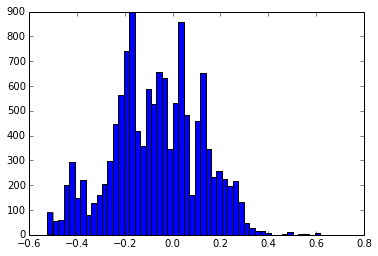

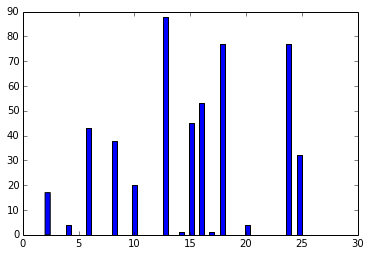

In [37]:
#howto run
env.prepare_sessions()
env._greediness.set_value(T.constant(10.,dtype=floatX).eval())

pred_history = predict()
hid_history,resp_history,dec_history = pred_history
print [channel.shape for channel in pred_history]

plt.hist(resp_history.ravel(),bins=50)
plt.show()
_= plt.hist(dec_history.argmax(-1).ravel(),bins=50)


# learning

In [38]:
def get_feedback(env,response_history,decision_history,strict = True):
    """env is an environment interface implementer instance
    Assumes response and decision shapes to be [batch_id,seq_length,unit]"""
    
    #channel, sequence, batch,unit shape is assumed to than split into two channel variables
    # 2x[sequence,batch,unit] cuz T.scan works along axis 0
    
    
    
    _predicted_Qvalues = response_history.dimshuffle(1,0,2)
    _commited_actions =  decision_history.dimshuffle(1,0,2)

    
    #init a variable in which ones indicate inputs that were tried 
    # already within a session (used in T.scan later)
    _attempted_init =T.zeros_like(env._event,dtype=floatX) #

    
    _batch_shaped = _commited_actions[0,:,0]
    outputs_info = [_attempted_init,
                    T.zeros_like(_batch_shaped,dtype=floatX),
                    T.ones_like(_batch_shaped,dtype='int8')
                   ]
    non_sequences = [env._event,env._greediness]
    
    _commited_action_ids = T.argmax(_commited_actions,-1)
    
    
    sequences = [_commited_action_ids]
    
    def reward_computation_step(decision_code,

                                fields_attempted_ext,
                                last_reward,
                                session_active,

                                event_arr_ext,*args):
        """i am used to compute the stepwise reward function via scan
        decision_code - int32 vector (batch_i) - what decision was taken during THIS STEP
        fields_attempted - int8 matrix (batch_i, array field id) - what fields were checked already
        last_reward - float32 vector (batch_i) - reward on previous step
        session_active - int8 vector (batch_i) - whether session is still not finished AFTER PREVIOUS_STEP
        event_arr - an array (int8) of game stage"""



        batch_i = T.arange(decision_code.shape[0],dtype='int32')
        ones_batch = T.ones_like(decision_code,dtype=floatX,)
        zeros_batch = T.zeros_like(decision_code,dtype=floatX,)


        #step

        has_finished_now = T.eq(decision_code,env.end_code)

        session_still_active = session_active*(1-has_finished_now) # array [batch_i] of bool

        is_first_time = T.eq(fields_attempted_ext[batch_i,decision_code],0)

        first_time_reward = env._greediness*(2*event_arr_ext[batch_i,decision_code] -1.).astype(floatX)

        current_reward = T.switch(session_still_active,                                
                                        T.switch(is_first_time,
                                                    first_time_reward,
                                                    -0.5*ones_batch
                                                ),
                                        0.*zeros_batch
                                )


        fields_attempted_now_ext = T.set_subtensor(
            fields_attempted_ext[batch_i,decision_code], ones_batch)

        #current_reward
        return fields_attempted_now_ext,current_reward,session_still_active

    attempted_ext,rewards,session_is_alive = theano.scan(
                                            reward_computation_step,
                                            sequences,
                                            outputs_info,
                                            non_sequences,
                                            strict=True)[0]
    attempted_ext = attempted_ext[-1]
    
    #take account for that rewards indicate whether session lasts for the NEXT step (and we wand current step)
    #shape so far: seq_len, batch_i (will be transposed later in this function)
    
    session_is_alive = T.vertical_stack(
        T.ones_like(_batch_shaped,dtype='int8').reshape([1,-1]),# padding
        session_is_alive[:-1,:], #actual session status for current step

    )
    
    _commited_actions = _commited_actions.dimshuffle([1,0,2])
    _predicted_Qvalues = _predicted_Qvalues.dimshuffle([1,0,2])
    
    return rewards.T,session_is_alive.T,attempted_ext,\
            _commited_action_ids.T,_predicted_Qvalues

In [39]:
def get_reference_tuples(_rewards,_isalive,_attempts,_decision_ids,_activations,
                            _gamma = _shared('q_learning_gamma',np.float32(0.99),floatX)
                        ):
    """computes three vectors:
      action IDs (1d,single integer) vector of all actions that were commited during all sequences
      in the batch, concatenated in one vector... that is, excluding the ones that happened
      after the end_code action was sent.
    
      Qpredicted - activations for action_IDs ONLY at each time 
      before sequence end action was committed for each sentence in the batch (concatenated) 
      but for the last time-slot.
      
      Qreference - sum over immediate rewards and gamma*predicted activations for
      next round after first vector predictions"""
    _alive_selector = _isalive[:,:-1].nonzero() # number of: [batch,time] but for (seq_len)-th

    _next_selector = (_alive_selector[0],_alive_selector[1]+1) # number of: [batch,time+1]


    # predictions for Qvalues in the order of _alive_selector (id, n_outputs)
    _predicted_Qvalues = _activations[_alive_selector]
    
    #iterator array over all prediction samples
    _event_i = T.arange(_predicted_Qvalues.shape[0])
    # corresponding choices
    _chosen_action_IDs = _decision_ids[_alive_selector]
    
    #predictions that resulted in actions
    _tested_predicted_Qvalues = _predicted_Qvalues[_event_i, :]#_chosen_action_IDs]

    # corresponding rewards (immediate)
    _immediate_rewards = _rewards[_alive_selector]
    # corresponding rewards for different next turn actions
    _predicted_next_rewards =_activations[_next_selector]
    
    #best of _predicted_next_rewards for each time
    _optimal_next_rewards = T.max(_predicted_next_rewards,axis=1)
    
    #full rewards from taking _chosen_action and behaving optimally later on
    _reference_Qvalues = _immediate_rewards + _gamma*_optimal_next_rewards
    return _chosen_action_IDs,_immediate_rewards, _tested_predicted_Qvalues,_reference_Qvalues

In [40]:
_gamma = _shared('q_learning_gamma',np.float32(0.99),floatX)

_hid_history,_resp_history,_dec_history  = _prediction

_feedback = get_feedback(env,_resp_history,_dec_history)
args = _feedback + (_gamma,)
_action_ids,_rewards, _predicted_Qvalues, _reference_Qvalues= get_reference_tuples(* args)


_loss = lasagne.objectives.squared_error(_predicted_Qvalues[T.arange(_action_ids.shape[0]),_action_ids]
                                         ,_reference_Qvalues)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:54: UserWarning: Warning, Cannot compute test value: input 0 (argmax[t]) of Op Elemwise{eq,no_inplace}(argmax[t], DimShuffle{x}.0) missing default value
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:58: UserWarning: Warning, Cannot compute test value: input 0 (AdvancedSubtensor.0) of Op Elemwise{eq,no_inplace}(AdvancedSubtensor.0, DimShuffle{x}.0) missing default value
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:65: UserWarning: Warning, Cannot compute test value: input 0 (Elemwise{eq,no_inplace}.0) of Op Elemwise{switch,no_inplace}(Elemwise{eq,no_inplace}.0, Elemwise{mul,no_inplace}.0, Elemwise{mul,no_inplace}.0) missing default value
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:65: UserWarning: Warning, Cannot compute test value: input 1 (Elemwise{mul,no_inplace}.0) of Op Elemwise{switch,no_inplace}(Elemwise{eq,no_inplace}.0, Elemwise{mul,no_inplace}.0, Elemwise{mul,no_inplace

# training, finally

In [41]:
_weights = lasagne.layers.get_all_params(_rnn)
_weights

[mdp_gru.W_in_to_updategate,
 mdp_gru.W_hid_to_updategate,
 mdp_gru.b_updategate,
 mdp_gru.W_in_to_resetgate,
 mdp_gru.W_hid_to_resetgate,
 mdp_gru.b_resetgate,
 mdp_gru.W_in_to_hidden_update,
 mdp_gru.W_hid_to_hidden_update,
 mdp_gru.b_hidden_update]

In [42]:
_updates = lasagne.updates.nesterov_momentum(_loss.mean(),_weights,learning_rate=0.01)

In [43]:
train_fun = theano.function([],_rewards.mean(),updates=_updates)

In [ ]:
env.change_shape(10,50)
env.prepare_sessions()
ma_reward = train_fun()
alpha = 0.01

In [ ]:
for i in range(100000):
    env.prepare_sessions()
    reward = train_fun()
    ma_reward = alpha*reward + (1-alpha)*ma_reward
    
    if i%100 ==0:
        print i, ma_reward

0 -0.438522298336
100 -0.611358943435
200 -0.711723060612
300 -1.11051977434
400 -1.23299066641
500 -1.38000530373
600 -1.4067920794
700 -1.42110426945
800 -1.3794174259
900 -1.33328930488
1000 -1.29995081921
1100 -1.28573163464
1200 -1.28370431544
1300 -1.27075906745
1400 -1.25109659927
1500 -1.27205068585
1600 -1.25246412894
1700 -1.22673681028
1800 -1.24733212395
1900 -1.22857507803
2000 -1.24271071469
2100 -1.26482703171
2200 -1.27371480264
2300 -1.24932670105
2400 -1.22879875972
2500 -1.22617630826
2600 -1.27603045065
2700 -1.28055995437
2800 -1.27852750791
2900 -1.28381090616
3000 -1.27236836728
3100 -1.26473739541
3200 -1.27886573668
3300 -1.26238022002
3400 -1.25277865639
3500 -1.26786825878
3600 -1.24920442745
3700 -1.26852969334
3800 -1.25652912389
3900 -1.28859050103
4000 -1.2732221794
4100 -1.28092901206
4200 -1.28741200309
4300 -1.3078457365
4400 -1.31101250411
4500 -1.31208737329
4600 -1.30650263745
4700 -1.28854295047
4800 -1.30334301772
4900 -1.33879756276
5000 -1.38621

0.79397535

In [238]:
theano.printing.pydotprint(_prediction,'graph_prediction.png')

The output file is available at graph_prediction.png


In [148]:
theano.printing.pydotprint(_loss,'graph_loss.png')

TypeError: must be string or buffer, not list

In [124]:
_nn_params = lasagne.layers.get_all_params(_rnn)
_nn_params

[mdp_gru.W_in_to_updategate,
 mdp_gru.W_hid_to_updategate,
 mdp_gru.b_updategate,
 mdp_gru.W_in_to_resetgate,
 mdp_gru.W_hid_to_resetgate,
 mdp_gru.b_resetgate,
 mdp_gru.W_in_to_hidden_update,
 mdp_gru.W_hid_to_hidden_update,
 mdp_gru.b_hidden_update]